MAE: 18656.84
RMSE: 29017.06
R-squared: 0.89


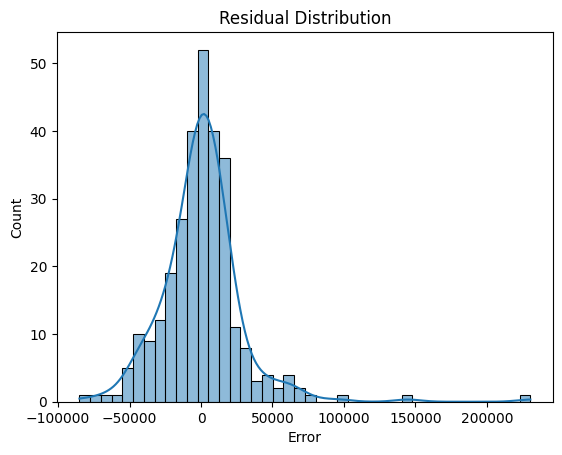

     Neighborhood  GrLivArea  LotArea  OverallQual  OverallCond  GarageCars  \
892        Sawyer       1068     8414            6            8           1   
1105      NoRidge       2622    12256            8            5           2   
413       OldTown       1028     8960            5            6           2   
522       BrkSide       1664     5000            6            7           2   
1036       Timber       1620    12898            9            5           3   

      TotalBaths  HasFireplace  Actual  Predicted  
892          1.5             0  154500  144151.50  
1105         3.5             1  325000  315322.47  
413          1.0             1  115000  117887.00  
522          2.0             1  159000  169855.50  
1036         3.0             1  315500  308839.31  


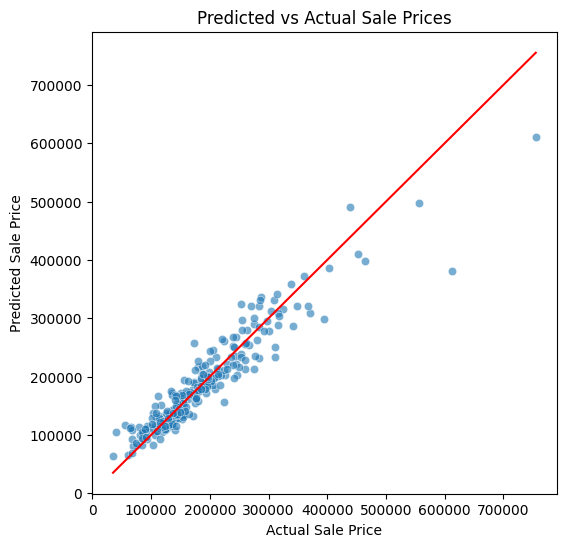

In [ ]:
# House Price Prediction Project - Based on Ames Housing (train.csv)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("train.csv")

# --- Feature Engineering ---
df["PricePerSqFt"] = df["SalePrice"] / df["GrLivArea"]
df["TotalBaths"] = df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"]
df["HasFireplace"] = df["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)

# Select features based on location, size, and amenities
features = [
    "Neighborhood", "GrLivArea", "LotArea", "OverallQual", "OverallCond", 
    "GarageCars", "TotalBaths", "HasFireplace"
]
X = df[features]
y = df["SalePrice"]

# --- Preprocessing ---
categorical = ["Neighborhood"]
numerical = list(set(features) - set(categorical))

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical),
    ("cat", categorical_pipeline, categorical)
])

# --- Model Pipeline ---
model = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# --- Evaluation ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

# Plot residuals
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Error")
plt.show()


results = X_test.copy()
results["Actual"] = y_test
results["Predicted"] = y_pred
print(results.head())

#The red line is the actual price, the dots are the predicted price. Here we want
#the dots to be as close to the line as possible. Under the line is underestimating
#and over the line is overestimating.
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Predicted vs Actual Sale Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()

results.to_csv("train_predictions_with_actual.csv", index=False)



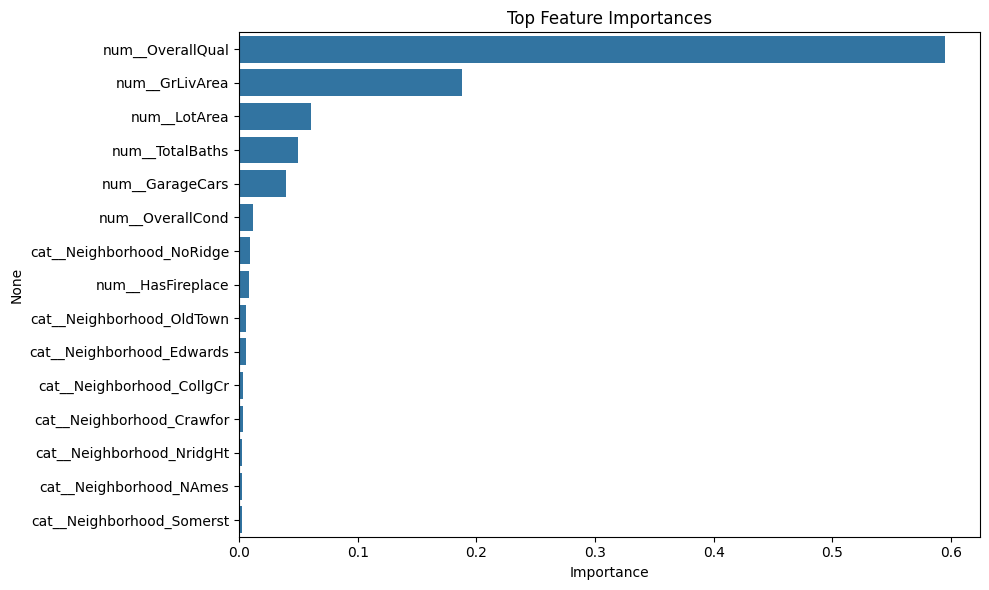

In [ ]:
#The longer the bar, the more important it was when predicting the price.

importances = model.named_steps["regressor"].feature_importances_
feature_names = model.named_steps["preprocess"].get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Top Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Save feature importances for reporting
feat_imp.to_csv("feature_importance.csv")

In [11]:
results = X_test.copy()
results["Actual"] = y_test
results["Predicted"] = y_pred
results.to_csv("house_price_predictions.csv", index=False)

In [ ]:
# Load test set
test_df = pd.read_csv("test.csv")

test_df["TotalBaths"] = test_df["FullBath"] + 0.5 * test_df["HalfBath"] + test_df["BsmtFullBath"] + 0.5 * test_df["BsmtHalfBath"]
test_df["HasFireplace"] = test_df["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)

# Keep same features used for training
X_test_final = test_df[[
    "Neighborhood", "GrLivArea", "LotArea", "OverallQual", "OverallCond", 
    "GarageCars", "TotalBaths", "HasFireplace"
]].copy()

# Handle any missing values and align columns
X_test_final.fillna(0, inplace=True)
missing_cols = [col for col in X.columns if col not in X_test_final.columns]
for col in missing_cols:
    X_test_final[col] = 0

# Predict using trained model pipeline
predictions = model.predict(X_test_final)

# Preview predictions with input features
test_preview = test_df[[
    "Id", "Neighborhood", "GrLivArea", "LotArea", "OverallQual", 
    "OverallCond", "GarageCars", "TotalBaths", "HasFireplace"
]].copy()
test_preview["PredictedSalePrice"] = predictions

# Display top 10 predicted rows
print(test_preview.head(10))

# Save submission
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": predictions
})
submission.to_csv("submission.csv", index=False)
print("✅ Predictions saved to submission.csv")


     Id Neighborhood  GrLivArea  LotArea  OverallQual  OverallCond  \
0  1461        NAmes        896    11622            5            6   
1  1462        NAmes       1329    14267            6            6   
2  1463      Gilbert       1629    13830            5            5   
3  1464      Gilbert       1604     9978            6            6   
4  1465      StoneBr       1280     5005            8            5   
5  1466      Gilbert       1655    10000            6            5   
6  1467      Gilbert       1187     7980            6            7   
7  1468      Gilbert       1465     8402            6            5   
8  1469      Gilbert       1341    10176            7            5   
9  1470        NAmes        882     8400            4            5   

   GarageCars  TotalBaths  HasFireplace  PredictedSalePrice  
0         1.0         1.0             0           120734.50  
1         1.0         1.5             0           150346.00  
2         2.0         2.5             1    

In [5]:
sample = pd.DataFrame([{
    "Neighborhood": "NAmes",
    "GrLivArea": 1500,
    "LotArea": 8000,
    "OverallQual": 6,
    "OverallCond": 5,
    "GarageCars": 2,
    "TotalBaths": 2.5,
    "HasFireplace": 1
}])


In [6]:
predicted_price = model.predict(sample)[0]
print(f"Predicted Sale Price: ${predicted_price:,.2f}")

Predicted Sale Price: $169,495.00
